### Import Packages

## Development of Hyperparameter Optimization Grids for the Engineering Data

### Predicting materials properties

https://apmonitor.com/pds/index.php/Main/AdditiveManufacturing

- Inputs: Layer Height, Wall Thickness, Infill Density, Infill Pattern, Nozzle Temperature, Bed Temperature, Print Speed, Material (PLA or ABS), Fan Speed

- Output: Tension Strength (the maximum stress that a material can withstand while being stretched or pulled before breaking)

In [ ]:
# Plotting and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Examining and preprocessing data
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Linear methods
from sklearn.linear_model import LogisticRegression, ElasticNetCV, LassoCV, RidgeCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.svm import SVC

# Ensemble methods based on bagging or boosting
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor 
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Hyperparameter optimization and defining pipelines
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import cross_validate, cross_val_predict,KFold
from sklearn.pipeline import Pipeline

# Feature Selection Methods
import shap 
from boruta import BorutaPy

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_score, recall_score, accuracy_score, explained_variance_score, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
import sklearn

import time 
import warnings
warnings.filterwarnings('ignore')

### Background:

The A 3D print data set of additive manufacturing test conditions for Polylactic Acid (PLA) and Acrylonitrile Butadiene Styrene (ABS).

PLA can print at lower temperatures of 180°C compared to 250°C for ABS.
PLA is more brittle than ABS and is not typically suitable for high strength applications.
The data was collected by researchers in the Mechanical Engineering department at Selçuk Üniversitesi on a Ultimaker S5 3D printer.

The study focused on how the parameters in a specific 3D printer affects the

- print quality,
- accuracy and
- final part strength.

This work is based on the settings and PLA or ABS filaments.

Material and strength tests were carried out on a Sincotec GMBH tester capable of pulling 20 kN.

Nine parameters (inputs) were adjusted for the Ultimaker S5 3D printer. Note that the project input specifications are: Layer Height, Wall Thickness, Infill Density, Infill Pattern, Nozzle Temperature, Bed Temperature, Print Speed, Material (PLA or ABS), Fan Speed.  These include all the input features of the data set.

- Layer Height (mm)
- Wall Thickness (mm)
- Infill Density (%)
- Infill Pattern (Honeycomb or Grid)
- Nozzle Temperature (ºC)
- Bed Temperature (ºC)
- Print Speed (mm/s)
- Material (PLA or ABS)
- Fan Speed (%)

After the part was manufactured, three parameters were measured for each product.

- Roughness (µm)
- Tension Strength (MPa):maximum stress that a material can withstand while being stretched or pulled before breaking
- Elongation (%)

In this project, the specified output is Tension Strength (the maximum stress that a material can withstand while being stretched or pulled before breaking).  Thus, the analysis will be limited to this singular output.

The labeled data is a combination of PLA and ABS material, print patterns, and conditions with 66 samples from a first repository and 50 samples from a second repository. The combined set is 70 samples with the duplicates removed and one outlier added.

The label associated with each filament is pla or abs.

The print pattern is grid or honeycomb.

One-hot encoding translates character labels into a binary representation (0 or 1) for classification.

### Import Data

In [7]:
url = 'http://apmonitor.com/pds/uploads/Main/manufacturing.txt'
data_print = pd.read_csv(url)

# 'material' (1 is abs, 0 is pla) with numpy.where
data_print['material'] = np.where(data_print['material']=='abs',1,0)

# 'infill pattern' (1 is 'grid', 0 is 'honeycomb') with list comprehension
data_print.infill_pattern = [1 if ip=="grid" else 0 for ip in data_print.infill_pattern]

## Part 1: Data Visualization and Cleansing


### Exploratory Data Analysis

### Summary statistics to describe the [dataset]( https://apmonitor.com/pds/index.php/Main/StatisticsMath).

In [3]:
data_print.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strength,elongation
0,0.02,8.0,90,1,220,60,40,1,0,25,18,1.2
1,0.02,7.0,90,0,225,65,40,1,25,32,16,1.4
2,0.02,1.0,80,1,230,70,40,1,50,40,8,0.8
3,0.02,4.0,70,0,240,75,40,1,75,68,10,0.5
4,0.02,6.0,90,1,250,80,40,1,100,92,5,0.7


### Determination of the number of features and the number of samples

In [10]:
data_print.head()
print(f'The number of samples in this dataset is {data_print.shape[0]}.')
print(f'The number of features for each output is {data_print.shape[1] - 1}.')

The number of samples in this dataset is 70.
The number of features for each output is 11.


### Statistical general description

In [11]:
data_print.describe()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strength,elongation
count,70.000000,70.000000,70.000000,70.00000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,0.097286,5.464286,54.600000,0.50000,221.785714,73.214286,68.857143,0.514286,48.614286,155.185714,19.942857,1.642143
std,0.061971,2.934455,27.926612,0.50361,14.843037,24.197792,45.501803,0.503405,36.060454,96.070520,9.282812,0.756596
min,0.020000,1.000000,10.000000,0.00000,200.000000,60.000000,40.000000,0.000000,0.000000,-1.000000,4.000000,0.400000
25%,0.052500,3.000000,32.500000,0.00000,210.000000,65.000000,40.000000,0.000000,25.000000,75.000000,12.000000,1.100000
50%,0.100000,5.500000,50.000000,0.50000,220.000000,70.000000,60.000000,1.000000,50.000000,141.000000,18.500000,1.500000
75%,0.150000,8.000000,80.000000,1.00000,230.000000,75.000000,63.750000,1.000000,75.000000,218.000000,27.000000,2.175000
max,0.200000,12.000000,100.000000,1.00000,250.000000,260.000000,360.000000,1.000000,100.000000,368.000000,38.000000,3.300000


### Convert dataframe to numpy arrays for future analysis

### Stipulated input variables in Project PDF

Inputs: Layer Height, Wall Thickness, Infill Density, Infill
Pattern, Nozzle Temperature, Bed Temperature, Print Speed,
Material (PLA or ABS), Fan Speed

### Stipulated output variables in Project PDF
Output: Tension Strength

In [12]:
# dropping unwanted columns
data_print = data_print.drop(columns=['roughness', 'elongation'])

In [15]:
# Forcing data into numpy arrays
# print(credit_data['Amount'].dtype) # From kaggle, all columns of data are integer variables

y = data_print['tension_strength'].to_numpy() # Label output data
X = data_print.drop('tension_strength', axis=1).to_numpy() #Label input data

print(X.shape)
print(y.shape)
# print(y)

(70, 9)
(70,)


In [16]:
# Print a general overview of the data
def dataoveriew(df, message):
    print(f'{message}:n')
    print('Number of rows: ', df.shape[0])
    print("nNumber of features:", df.shape[1])
    print("nData Features:")
    print(df.columns.tolist())
    print("nMissing values:", df.isnull().sum().values.sum())
    print("nUnique values:")
    print(df.nunique())

dataoveriew(data_print, 'Overview of the dataset')

Overview of the dataset:n
Number of rows:  70
nNumber of features: 10
nData Features:
['layer_height', 'wall_thickness', 'infill_density', 'infill_pattern', 'nozzle_temperature', 'bed_temperature', 'print_speed', 'material', 'fan_speed', 'tension_strength']
nMissing values: 0
nUnique values:
layer_height           9
wall_thickness        12
infill_density        13
infill_pattern         2
nozzle_temperature    10
bed_temperature        9
print_speed            8
material               2
fan_speed              6
tension_strength      27
dtype: int64


### Determine missingness

In [ ]:
print(f'There is {data_print.isnull().sum().to_numpy().sum() / (data_print.shape[0] * data_print.shape[1])}% missingness in our dataset.')

There is 0.0% missingness in our dataset.


In [18]:
# find column names:
data_print.columns

Index(['layer_height', 'wall_thickness', 'infill_density', 'infill_pattern',
       'nozzle_temperature', 'bed_temperature', 'print_speed', 'material',
       'fan_speed', 'tension_strength'],
      dtype='object')

In [19]:
# Determine Correlation
corrmat2 = data_print.corr()
round(corrmat2,2)

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,tension_strength
layer_height,1.00,-0.28,0.02,-0.01,-0.01,0.06,0.12,-0.02,-0.05,0.33
wall_thickness,-0.28,1.00,0.03,-0.21,-0.11,-0.08,-0.31,-0.10,0.03,0.31
infill_density,0.02,0.03,1.00,0.19,0.21,0.19,0.09,0.10,0.01,0.33
infill_pattern,-0.01,-0.21,0.19,1.00,0.09,0.13,0.07,0.11,-0.02,-0.06
nozzle_temperature,-0.01,-0.11,0.21,0.09,1.00,0.14,-0.02,0.72,0.57,-0.38
bed_temperature,0.06,-0.08,0.19,0.13,0.14,1.00,0.72,-0.11,0.16,0.08
print_speed,0.12,-0.31,0.09,0.07,-0.02,0.72,1.00,-0.08,-0.10,0.01
material,-0.02,-0.10,0.10,0.11,0.72,-0.11,-0.08,1.00,0.02,-0.35
fan_speed,-0.05,0.03,0.01,-0.02,0.57,0.16,-0.10,0.02,1.00,-0.30
tension_strength,0.33,0.31,0.33,-0.06,-0.38,0.08,0.01,-0.35,-0.30,1.00


### Correlation matrix

<AxesSubplot:>

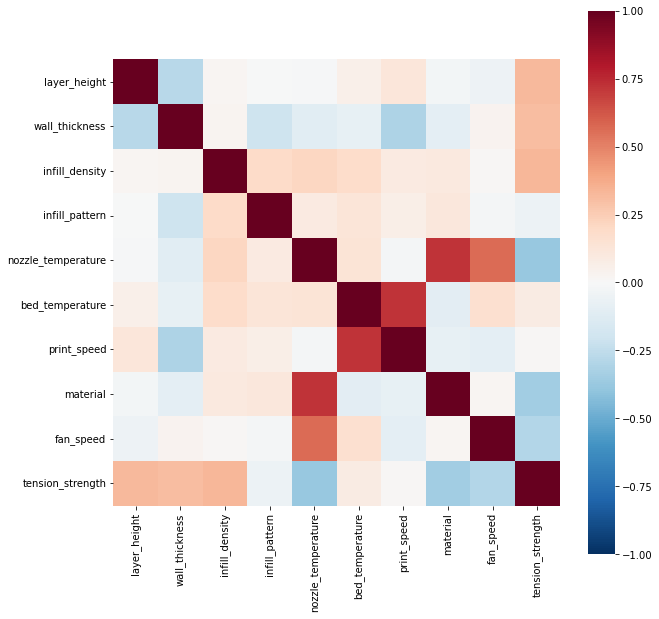

In [20]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    data_print.corr(), vmin=-1, vmax=1, square=True, cmap = "RdBu_r"
)  # Linear correlation matrix, vmin=-1, vmax=1 is because correlation is measured between -1,1

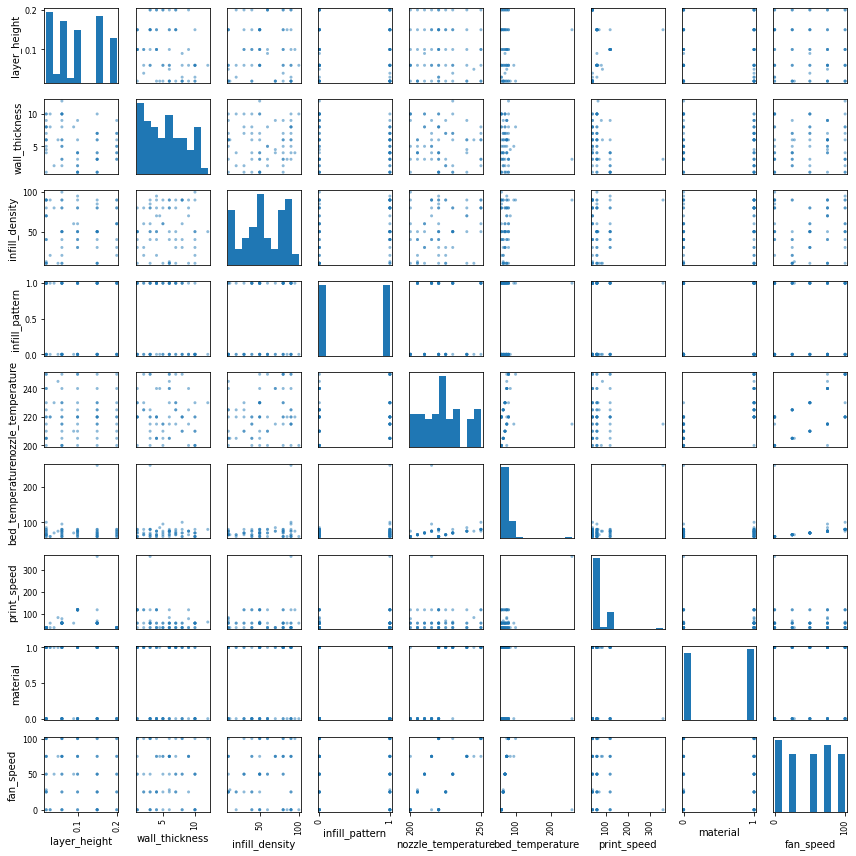

In [ ]:
pd.plotting.scatter_matrix(data_print.iloc[:, :-1], figsize=(12, 12))
plt.tight_layout()
plt.show()

In [21]:
# Check data types of all the columns
data_print.dtypes

layer_height          float64
wall_thickness        float64
infill_density          int64
infill_pattern          int64
nozzle_temperature      int64
bed_temperature         int64
print_speed             int64
material                int64
fan_speed               int64
tension_strength        int64
dtype: object

### All of data is either a float or an integer

### Feature distributions

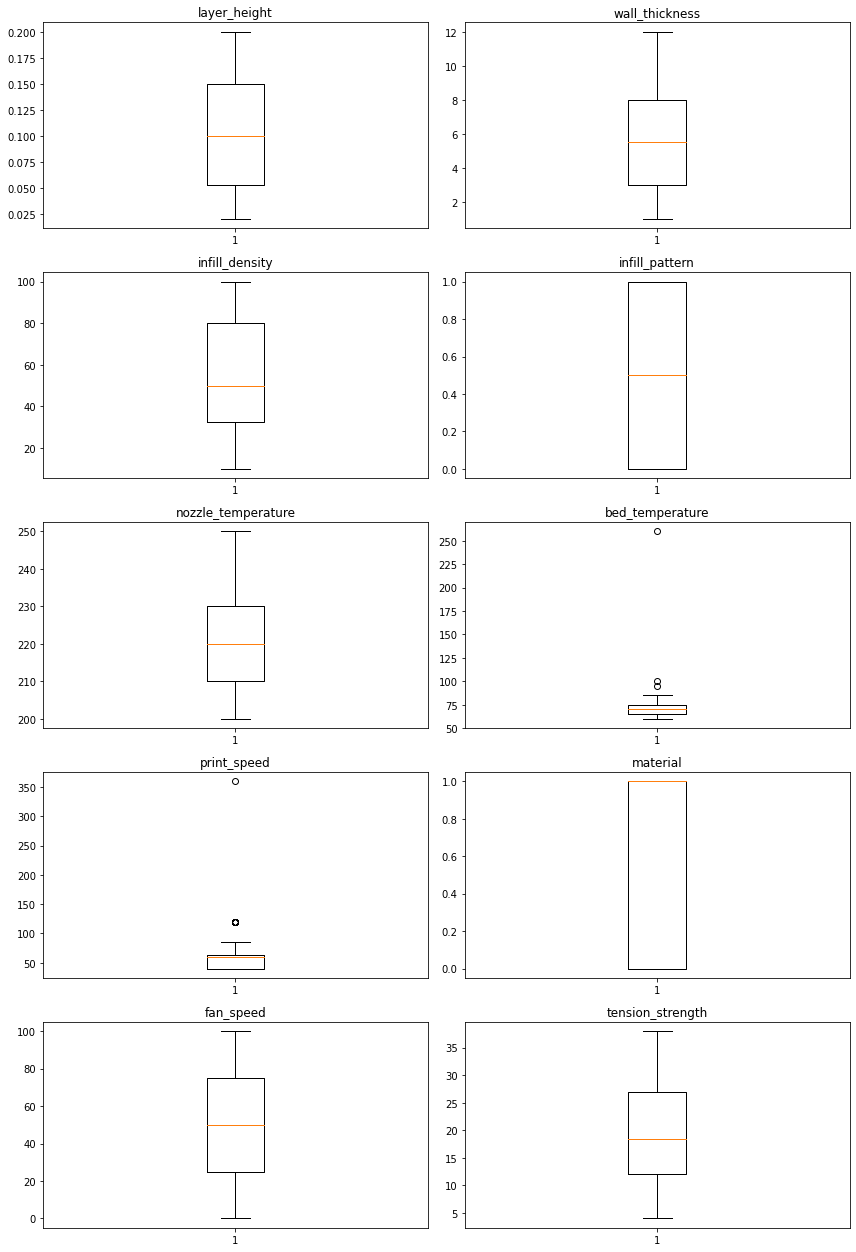

In [22]:
import math

n = len(data_print.columns)
rows = math.ceil(n/2)
cols = min(n, 2)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize = (12, 3.5*rows))

# Plot each column in a separate subplot
for i, col in enumerate(data_print.columns):
    ax = axes[i//cols, i%cols] if n > 1 else axes
    ax.boxplot(data_print[col])
    ax.set_title(col)

# Hide any empty subplots
for i in range(n, rows*cols):
    ax = axes[i//cols, i%cols] if n > 1 else axes
    ax.axis('off')

# Adjust the layout of the subplots
fig.tight_layout()

## Assessment of feature distributions:

It is important to check the distributions of the features to ensure that they are suitable for the modeling technique being used. For example, some models assume that the data is normally distributed, while others can handle non-normal distributions.  In this dataset, we see that all of features have a non-normal distribution.

Distributions also enable us to check for any outliers or anomalies in the data. Outliers can have a significant impact on the results of the modeling and may need to be treated separately.

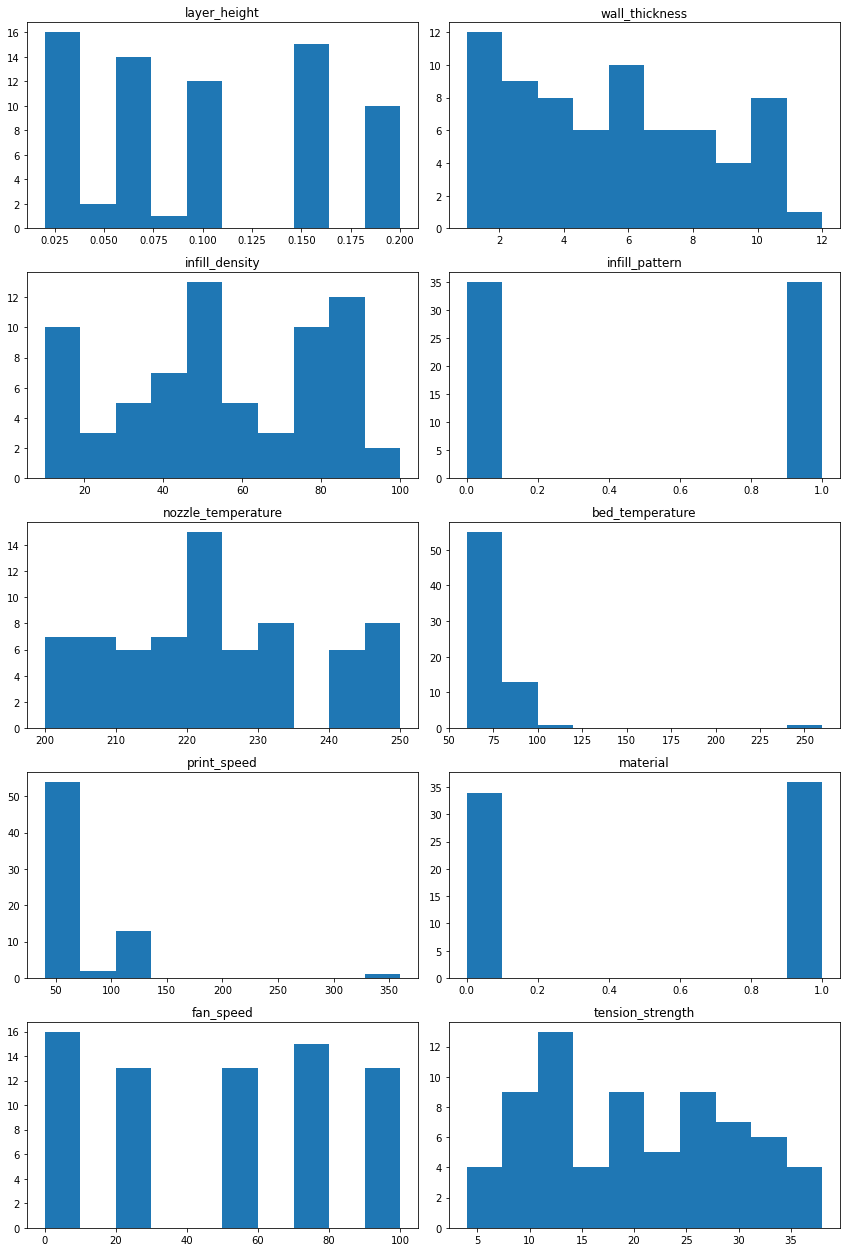

In [24]:
import math

n = len(data_print.columns)
rows = math.ceil(n/2)
cols = min(n, 2)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize = (12, 3.5*rows))

# Plot each column in a separate subplot
for i, col in enumerate(data_print.columns):
    ax = axes[i//cols, i%cols] if n > 1 else axes
    ax.hist(data_print[col])
    ax.set_title(col)

# Hide any empty subplots
for i in range(n, rows*cols):
    ax = axes[i//cols, i%cols] if n > 1 else axes
    ax.axis('off')

# Adjust the layout of the subplots
fig.tight_layout()

### Observations of the feature distributions and comments on the analytics relevant to the observations

- The features in this data do not have normal distributions, so it will be useful to implement models that are less sensitive to non-normality, such as decision trees, random forests, or support vector machines with nonlinear kernels. These models can handle nonlinear relationships between features and the outcome, and may be less affected by non-normality than linear models like logistic regression.

- In addition, we will preprocess the data to improve the performance of the model. One common approach is to standardize the data using StandardScaler from sklearn.preprocessing. Standardization scales each feature to have a mean of 0 and a standard deviation of 1, which can help to mitigate the effects of different feature scales and non-normality.

- Another approach is to use normalization techniques such as MinMaxScaler or RobustScaler, which can be helpful if the data has outliers or if you want to preserve the scale of the data.

- Here we plan to try multiple preprocessing methods and compare their performance on the data to choose the best one for our needs.

### Determine duplicates

In [25]:
# Examination for duplicates; if detected, they will be removed and only one of the duplicates will be retained
print(data_print.shape)# (284807, 31)
data_print = data_print.drop_duplicates(keep='first') 
print(data_print.shape)
# Results show that there are no duplicates

(70, 10)
(70, 10)


### Data preprocessing

In [26]:
# Forcing data into numpy arrays

y = data_print['tension_strength'].to_numpy() # Label output data
X = data_print.drop('tension_strength', axis=1).to_numpy() #Label input data

print(X.shape)
print(y.shape)
print(y)

(70, 9)
(70,)
[18 16  8 10  5 24 12 14 27 25 37 12 16  9 10 27 23 26 33 29 16 12 10 19
  8 11 12 18 34 14 27 19 18  9 13 33 24 26 22  4 35 34 28 28 21 28 14 30
 29 27  5 38 26 18 37 12 27 12 19 14 19 18 33 33 29  9 12 10  5 16]


### Implement Standard Scaling of the features

The code below applies three different preprocessing methods: MinMaxScaler, StandardScaler, and RobustScaler. MinMaxScaler scales each feature to a range of 0 to 1, while StandardScaler scales each feature to have mean 0 and standard deviation 1. RobustScaler is a robust version of StandardScaler that scales each feature by subtracting the median and scaling by the interquartile range.

After applying each scaler, the transformed data is stored in separate variables: X_scaled_minmax, X_scaled_standard, and X_scaled_robust.

In [ ]:
# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled_minmax = scaler.fit_transform(X)

# Apply StandardScaler
scaler = StandardScaler()
X_scaled_standard = scaler.fit_transform(X)

# Apply RobustScaler
scaler = RobustScaler()
X_scaled_robust = scaler.fit_transform(X)


In [27]:
# Apply different preprocessing methods to X
scaler_minmax = MinMaxScaler()
X_scaled_minmax = scaler_minmax.fit_transform(X)

# Apply StandardScaler
scaler_standard = StandardScaler()
X_scaled_standard = scaler_standard.fit_transform(X)

# Apply RobustScaler
scaler_robust = RobustScaler()
X_scaled_robust = scaler_robust.fit_transform(X)

# Split data into train and test sets for each preprocessing method
X_train_minmax, X_test_minmax, y_train, y_test = train_test_split(X_scaled_minmax, y, test_size=0.2, random_state=42)
X_train_standard, X_test_standard, y_train, y_test = train_test_split(X_scaled_standard, y, test_size=0.2, random_state=42)
X_train_robust, X_test_robust, y_train, y_test = train_test_split(X_scaled_robust, y, test_size=0.2, random_state=42)

### Perform baseline regressors on the data to assess preliminary performance in models without hyperparameter optimizationa and without feature selection

In [44]:
# goal: linear regression with cross validation
def lr_cross_validation_experiment(X, y):
    
    scaler = StandardScaler()
    
    names = ['Linear Regression', 'XGBoost', 'Random Forest', 'Decision Tree', 'Lasso', 'Ridge', 'ElasticNet']
    regressors = [LinearRegression(), XGBRegressor(), RandomForestRegressor(), DecisionTreeRegressor(), 
                 Lasso(), Ridge(), ElasticNet()]
    for name, regressor in zip(names, regressors) :
        print('\t\t\t\tTraining Model :', name)
        print()
    
        cv = KFold(n_splits=5, shuffle=True, random_state=111)
        
        for train_indices, test_indices in cv.split(X, y):
            # Create a train/test split for this fold iteration
            X_train, y_train = X[train_indices], y[train_indices]
            X_test, y_test = X[test_indices], y[test_indices]

            # Standardize -> z = (x - mean) / std
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)  

            # Fit a model to this
            reg = regressor.fit(X_train, y_train)

            # Make predictions on training set
            y_pred_train = reg.predict(X_train)

            # Make predictions on the test set
            y_pred = reg.predict(X_test)
            
            print('R2 :', r2_score(y_test, y_pred))
            print('Explained Variance :', explained_variance_score(y_test, y_pred))
            print('MSE :', mean_squared_error(y_test, y_pred)) 
            print('RMSE :', mean_squared_error(y_test, y_pred, squared=False))
            print('')
            
        print('\n======================================================================================\n')           

In [45]:
lr_cross_validation_experiment(X_train_standard, y_train)

				Training Model : Linear Regression

R2 : 0.7324212338381951
Explained Variance : 0.7324774010706114
MSE : 25.960714875323443
RMSE : 5.095165833937443

R2 : 0.5476822701546039
Explained Variance : 0.6251690606295282
MSE : 26.653102593369205
RMSE : 5.16266429214308

R2 : 0.28380166011324226
Explained Variance : 0.4642180541679781
MSE : 44.546352942047434
RMSE : 6.6743054276866465

R2 : 0.3460112234163294
Explained Variance : 0.34601222256736774
MSE : 51.85428365738624
RMSE : 7.200991852334388

R2 : 0.2780093326244937
Explained Variance : 0.28442408509475803
MSE : 44.214469795475225
RMSE : 6.649396197811891



				Training Model : XGBoost

R2 : 0.5253147647138221
Explained Variance : 0.5381541393164175
MSE : 46.05435709849439
RMSE : 6.786336058470313

R2 : 0.5613621266537456
Explained Variance : 0.5614154552989592
MSE : 25.847008569907384
RMSE : 5.083995335354605

R2 : 0.22806878693432975
Explained Variance : 0.36546308732267174
MSE : 48.01284553332425
RMSE : 6.929130214776184

R2 : 0

## Next, tune hyperparameters for each of the models.  Note, linear regression has no hyperparameters, but the other regressors are optimimized as shown below.

## Models include the following:


lir = LinearRegression()
ridge = Ridge()
lasso = Lasso()
enet = ElasticNet()
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()
xgbr = XGBRegressor()




In [ ]:
param_grid_rfr = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [42]
}

param_grid_xgb = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10, 100]
}

param_grid_ridge = {
    'alpha': [0.01, 0.1, 1, 10, 100], # Regularization strength
    'fit_intercept': [True, False], # Whether to fit the intercept or not
    'normalize': [True, False], # Whether to normalize the features or not
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], # Solver to use for computing the coefficients
    'max_iter': [None, 10, 100, 1000], # Maximum number of iterations for the solver
    'tol': [1e-4, 1e-3, 1e-2, 1e-1], # Tolerance for stopping criterion
    'random_state': [42] # Random state for reproducibility
}

param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100], # L1 regularization strength
    'fit_intercept': [True, False], # Whether to calculate the intercept for this model
    'normalize': [True, False], # Whether to normalize the input data
    'max_iter': [500, 1000, 5000], # Maximum number of iterations for the solver to converge
    'tol': [1e-4, 1e-3, 1e-2, 1e-1] # Tolerance for stopping criterion
    'selection': ['cyclic', 'random']
}

def rand_grid_search_experiment(param_grid, cv=5):
    start_time = time.time()  # time denoted by computer as start time
   
    # Define the model the logistic regression model:
    rfr = RandomForestRegressor()
    ridge = Ridge()
    lasso = Lasso()
    enet = ElasticNet()
    gbr = GradientBoostingRegressor()
    xgbr = XGBRegressor()
    
    scoring = {'r2': 'r2', 
           'neg_mean_squared_error': 'neg_mean_squared_error', 
           'neg_root_mean_squared_error': 'neg_root_mean_squared_error', 
           'neg_mean_absolute_error': 'neg_mean_absolute_error', 
           'explained_variance': 'explained_variance'}
    
    # Set up grid search
    clf = RandomizedSearchCV(
        estimator=rfr,
        param_distributions=param_grid,
        scorer=scoring,  # ‘R2’,'Explained Variance’,'RMSE,'MSE’        
        n_iter=1000, # number of hyperparameter settings that are sampled
        cv=5, # number of cross-validation folds to estimate test error
        verbose=1,
        n_jobs=-1,
        refit='f1'
    )
    
    # Do the grid search
    clf.fit(X_rebal, y_rebal)
    # clf.fit(X_train, y_train) 
    
    # Save results
    results = clf.cv_results_ # A dictionary with the CV results (i.e. performance on train/val splits)
    results_df = pd.DataFrame.from_dict(results)  # Convert the results into a Pandas array
    #results_df.to_csv('results.csv', index=False) # Saves results as a .csv file
    results_df.to_csv('~/Desktop/results.csv', index=False) # Saves results as a .csv file
    
    # Print performance on test set
    print('Best parameters found by grid search are:', clf.best_params_)
    print('Best score found by grid search is:', round(clf.best_score_, 3))

    total_time = time.time() - start_time
    print(f'This experiment took {round(total_time, 3)} seconds to complete.')

    
    return clf